In [1]:
import os

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers, models
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
import numpy as np
import cv2
import time
import datetime
from keras.callbacks import TensorBoard

In [134]:
# tensorboard
%load_ext tensorboard

In [2]:
WORKING_DIR = "data"

In [137]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[]


In [3]:
images = os.listdir(WORKING_DIR)
train_images = images[-500:]

In [4]:
image_size = (256, 256)
sample_img = tf.io.read_file(f"{WORKING_DIR}/{train_images[0]}")
sample_img = tf.io.decode_png(sample_img)
print(sample_img.shape)

(500, 500, 3)


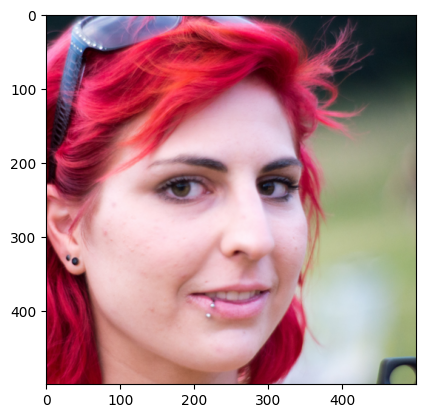

In [5]:
plt.figure()
plt.imshow(sample_img)

In [6]:
images = []

for file in train_images:
    img = cv2.imread(f"{WORKING_DIR}/{file}")
    img = cv2.resize(img, image_size)
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

X = np.array(images) / 255.0

In [7]:
def destory_patches(image):
    augmented_img = image.copy()
    for _ in range(np.random.randint(10, 40)):
        patch_size_x = np.random.randint(5, 10)
        patch_size_y = np.random.randint(5, 10)
        x = np.random.randint(1, image.shape[1] - patch_size_x)
        y = np.random.randint(1, image.shape[0] - patch_size_y)
        augmented_img[y:y + patch_size_y, x:x+patch_size_x, :] = 0.0

    return augmented_img

In [8]:
destoryed_images = []

for img in X:
    destoryed_images.append(destory_patches(img))

In [9]:
X_destoryed = np.array(destoryed_images)

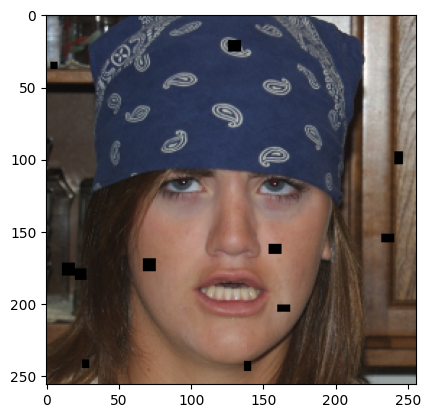

In [10]:
plt.figure()
plt.imshow(X_destoryed[196])

## unet

In [152]:
def build_unet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    up1 = layers.UpSampling2D(size=(2, 2))(conv2)

    # Output
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up1)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [153]:
input_shape = X.shape[1:]

model_unet = build_unet(input_shape)
model_unet.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [155]:
early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=4)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model_unet.fit(
    X_destoryed,
    X,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early, reduce, tensorboard_callback]
)

Epoch 1/20
13/13 [==============================] - 64s 5s/step - loss: 0.0150 - accuracy: 0.8197 - val_loss: 0.0114 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - 58s 4s/step - loss: 0.0085 - accuracy: 0.8200 - val_loss: 0.0081 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 3/20
13/13 [==============================] - 58s 4s/step - loss: 0.0057 - accuracy: 0.8383 - val_loss: 0.0051 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 4/20
13/13 [==============================] - 60s 5s/step - loss: 0.0045 - accuracy: 0.8790 - val_loss: 0.0044 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 5/20
13/13 [==============================] - 61s 5s/step - loss: 0.0038 - accuracy: 0.8886 - val_loss: 0.0037 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 6/20
13/13 [==============================] - 60s 5s/step - loss: 0.0032 - accuracy: 0.9008 - val_loss: 0.0033 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 7/20
13/13 [==============================] - 59s 5s/step - loss: 0.0029 - a

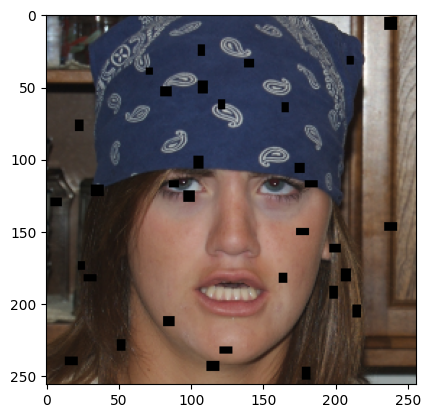

In [156]:
plt.figure()
plt.imshow(X_destoryed[196])

In [161]:
predicted = model_unet.predict(X_destoryed)

16/16 [==============================] - 14s 835ms/step


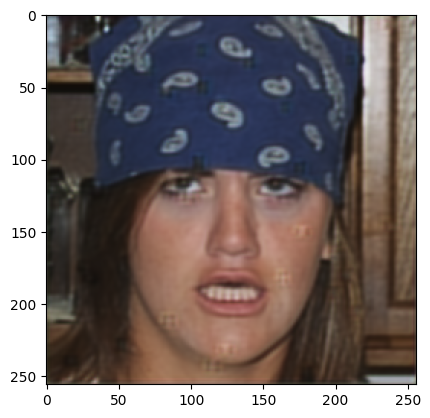

In [162]:
plt.figure()
plt.imshow(predicted[196])

In [163]:
%tensorboard --logdir logs/fit

In [29]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4),  # (batch_size, 2, 2, 1024)
    upsample(512, 4),  # (batch_size, 4, 4, 1024)
    upsample(512, 4),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [30]:
autoencoder = Generator()
autoencoder.compile(optimizer='adam', loss='mse')

In [31]:
early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
reduce = ReduceLROnPlateau(monitor='loss', patience=4),

autoencoder.fit(X_destoryed, X,
epochs=50,
batch_size=32,
shuffle=True, 
callbacks=[early, reduce])

Epoch 1/50
 4/16 [======>.......................] - ETA: 1:14 - loss: 0.1575

KeyboardInterrupt: 

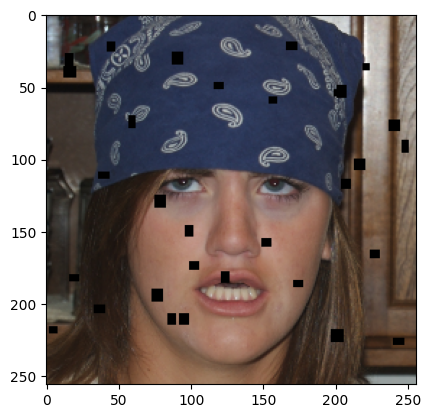

In [36]:
plt.figure()
plt.imshow(X_destoryed[196])

In [16]:
X_regenerated = autoencoder.predict(X_destoryed)

16/16 [==============================] - 2s 44ms/step


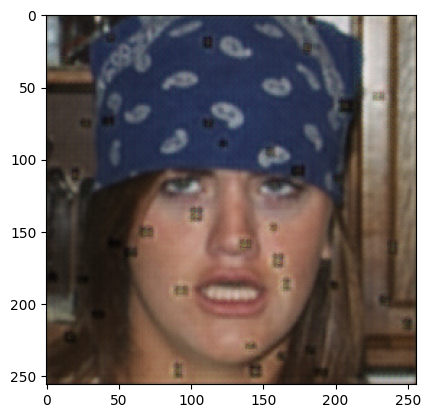

In [19]:
plt.figure()
plt.imshow(X_regenerated[196])

## context encoder

In [84]:

def build_channel_wise_fc(input_layer):
    channels = int(input_layer.shape[-1])
    channel_wise_fc = layers.Conv2D(channels, (1, 1), activation='relu', padding='same')(input_layer)
    return channel_wise_fc

def build_alexnet_encoder(inputs):
    # AlexNet-like encoder
    conv1 = layers.Conv2D(96, (11, 11), activation='relu', padding='same', strides=(4, 4))(inputs)
    conv2 = layers.Conv2D(256, (5, 5), activation='relu', padding='same', strides=(1, 1))(conv1)
    conv3 = layers.Conv2D(384, (3, 3), activation='relu', padding='same', strides=(1, 1))(conv2)
    conv4 = layers.Conv2D(384, (3, 3), activation='relu', padding='same', strides=(1, 1))(conv3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1))(conv4)

    # Pooling layer
    pool5 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv5)

    return pool5

def build_decoder(channel_wise_fc, input_shape):
    # Up-convolutional layers
    upconv1 = layers.Conv2DTranspose(256, (5, 5), activation='relu', padding='same', strides=(2, 2))(channel_wise_fc)
    upconv2 = layers.Conv2DTranspose(128, (5, 5), activation='relu', padding='same', strides=(2, 2))(upconv1)
    upconv3 = layers.Conv2DTranspose(64, (5, 5), activation='relu', padding='same', strides=(2, 2))(upconv2)
    upconv4 = layers.Conv2DTranspose(32, (5, 5), activation='relu', padding='same', strides=(2, 2))(upconv3)

    # Adjust the number of filters and kernel size to match the input shape
    upconv5 = layers.Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same', strides=(2, 2))(upconv4)

    return upconv5

In [11]:
input_shape = (256,256,3)


In [23]:
def build_contex(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    conv1 = layers.Conv2D(96, (11, 11), activation='relu', padding='same', strides=(4, 4))(inputs)
    conv2 = layers.Conv2D(256, (5, 5), activation='relu', padding='same', strides=(1, 1))(conv1)
    conv3 = layers.Conv2D(384, (3, 3), activation='relu', padding='same', strides=(2, 2))(conv2)
    conv4 = layers.Conv2D(384, (3, 3), activation='relu', padding='same', strides=(1, 1))(conv3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2, 2))(conv4)
    pool5 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv5)

    channel_wise_fc = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(pool5)
    # Decoder
    upconv1 = layers.Conv2DTranspose(256, (5, 5), activation='relu', padding='same', strides=(2, 2))(channel_wise_fc)
    upconv2 = layers.Conv2DTranspose(128, (5, 5), activation='relu', padding='same', strides=(2, 2))(upconv1)
    upconv3 = layers.Conv2DTranspose(64, (5, 5), activation='relu', padding='same', strides=(2, 2))(upconv2)
    upconv4 = layers.Conv2DTranspose(32, (5, 5), activation='relu', padding='same', strides=(2, 2))(upconv3)

    # Last upconv should match the input shape
    upconv5 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', strides=(2, 2))(upconv4)
    print(upconv5.shape)
    model = models.Model(inputs=inputs, outputs=upconv5)


    return model

In [1]:
model_context = build_contex(input_shape)
model_context.compile(optimizer='adam', loss='mse')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=4)

model_context.fit(
    X_destoryed,
    X,
    epochs=20,
    batch_size=32,
    callbacks=[early, reduce]
)

NameError: name 'build_contex' is not defined